In [3]:
import scanpy as sc
import pandas as pd
import os

In [7]:
base = "../data/zscore_results/"
files = [os.path.join(base, f) for f in os.listdir(base) if f.endswith(".csv")]

print(f"Found {len(files)} files")
for f in files:
    print(f)

Found 9 files
../data/zscore_results/Astrocytes_zscore_MacNair.csv
../data/zscore_results/MG_zscore_LermaMartin.csv
../data/zscore_results/Microglia_zscore_Trobisch.csv
../data/zscore_results/Oligodendrocyte_zscore_Trobisch.csv
../data/zscore_results/Oligodendrocytes_zscore_MacNair.csv
../data/zscore_results/AS_zscore_LermaMartin.csv
../data/zscore_results/Microglia_zscore_MacNair.csv
../data/zscore_results/Astrocyte_zscore_Trobisch.csv
../data/zscore_results/OL_zscore_LermaMartin.csv


In [8]:
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Optional

def find_consistent_zscores(
    files: List[str],
    include_keywords: Tuple[str, ...] = ("astro", "as"),  # case-insensitive match in filename
    z_thresh: float = 1.96,
    direction: str = "up",          # "up", "down", or "both"
    min_datasets: int = 2,          # require significance in at least this many datasets
    gene_col: Optional[str] = None, # if None, use first column
    z_col: Optional[str] = None,    # if None, auto-detect: a column containing "z" or the second column
    standardize_genes: bool = False,# if True, uppercase gene symbols
    save_table: Optional[str] = None,
    make_heatmap: bool = False,
    heatmap_top: int = 30,
    save_heatmap: Optional[str] = None,
):
    """
    Load multiple CSVs containing per-gene z-scores, filter to files whose names
    include any of `include_keywords`, and find genes consistently up/down.

    Returns
    -------
    merged : pd.DataFrame
        Wide table: gene × datasets (+ n_up, n_down if requested).
    hits   : pd.DataFrame
        Filtered table of consistent genes per requested direction.
    """
    # ---- pick only matching files (astro) ----
    def _keep(name: str) -> bool:
        low = name.lower()
        return any(k.lower() in low for k in include_keywords)

    selected = [f for f in files if _keep(Path(f).name)]
    if not selected:
        raise ValueError("No files matched include_keywords. Check filenames or keywords.")

    # ---- load & harmonize ----
    dfs = []
    for f in selected:
        df = pd.read_csv(f)
        cols = list(df.columns)

        # infer gene column
        gcol = gene_col or cols[0]

        # infer z column
        if z_col is not None:
            zc = z_col
        else:
            # prefer a column containing 'z' (case-insensitive), otherwise second column
            cand = [c for c in cols if c != gcol and "z" in c.lower()]
            zc = cand[0] if cand else cols[1]

        sub = df[[gcol, zc]].rename(columns={gcol: "gene", zc: Path(f).stem})
        if standardize_genes:
            sub["gene"] = sub["gene"].astype(str).str.upper()
        dfs.append(sub)

    # merge on gene (outer to keep unions)
    merged = None
    for d in dfs:
        merged = d if merged is None else pd.merge(merged, d, on="gene", how="outer")

    merged = merged.drop_duplicates("gene")
    merged = merged.set_index("gene")

    # ---- consistency masks ----
    up_mask = (merged > z_thresh)
    down_mask = (merged < -z_thresh)

    merged["n_up"] = up_mask.sum(axis=1)
    merged["n_down"] = down_mask.sum(axis=1)

    # ---- select hits by direction ----
    if direction == "up":
        hits = merged[merged["n_up"] >= min_datasets].sort_values(["n_up"], ascending=False)
    elif direction == "down":
        hits = merged[merged["n_down"] >= min_datasets].sort_values(["n_down"], ascending=False)
    elif direction == "both":
        hits = merged[(merged["n_up"] >= min_datasets) | (merged["n_down"] >= min_datasets)]\
               .sort_values(["n_up","n_down"], ascending=False)
    else:
        raise ValueError("direction must be 'up', 'down', or 'both'")

    # ---- save table ----
    if save_table:
        out = hits.reset_index()
        out.to_csv(save_table, index=False)

    # ---- optional heatmap (top hits) ----
    if make_heatmap:
        import seaborn as sns, matplotlib.pyplot as plt
        # Keep only data columns (exclude n_up/n_down)
        data_cols = [c for c in merged.columns if c not in ("n_up","n_down")]
        top = hits.copy()
        # pick top rows by chosen direction
        order_col = "n_up" if direction in ("up","both") else "n_down"
        top = top.sort_values(order_col, ascending=False).head(heatmap_top)
        if top.empty:
            print("No hits to plot.")
        else:
            sns.clustermap(top[data_cols], cmap="RdBu_r", center=0)
            if save_heatmap:
                plt.gcf().tight_layout()
                plt.savefig(save_heatmap, dpi=200, bbox_inches="tight")
            plt.show()

    return merged.reset_index(), hits.reset_index()

In [15]:
merged

,gene,Astrocytes_zscore_MacNair,AS_zscore_LermaMartin,Astrocyte_zscore_Trobisch,n_up,n_down
0,Astrocytes,-0.971967,NaN,NaN,0,1
1,AS,NaN,1.063634,NaN,1,0
2,Astrocyte,NaN,NaN,-0.239385,0,0


ValueError: The number of observations cannot be determined on an empty distance matrix.

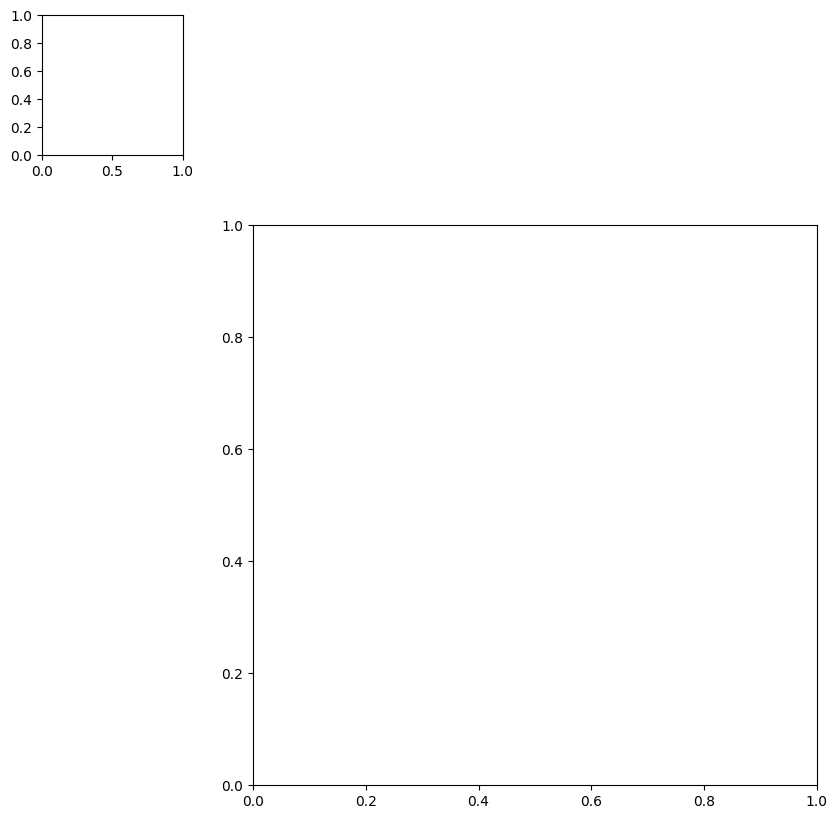

In [13]:
merged, hits = find_consistent_zscores(
    files,
    include_keywords=("Astro","As"),   # only astrocyte datasets
    z_thresh=0.5,
    direction="up",
    min_datasets=1,
    save_table=os.path.join(base, "astro_consistently_up.csv"),
    make_heatmap=True,
    save_heatmap=os.path.join(base, "astro_consistently_up_heatmap.png"),
)